In [1]:
import numpy as np
import pandas as pd
import os
import random
from glob import glob
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from PIL import Image

2023-12-01 14:22:18.405012: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 14:22:18.405038: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 14:22:18.405413: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 14:22:18.483269: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
""" 
This part of the code sets up an Image generator that will be used for the CNN
It doesn't actually compute any of the resizing or transformations yet, it just sets up the generator
The generator will be called when we train the model 
"""
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (299, 299) # resolution of the images for the dataset.


def getNumImagesPerClass(dataset_dir='data/train', class_type='ALL', output=False):
    class_counts = {}

    for subdir in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, subdir)):
            num_images = len(os.listdir(os.path.join(dataset_dir, subdir)))
            class_counts[subdir] = num_images

    if output:
        for class_name, count in class_counts.items():
            print(f"Class '{class_name}' has {count} images.")
    elif class_type in class_counts:
        return class_counts[class_type]
    else:
        return class_counts


getNumImagesPerClass(output=True)
getNumImagesPerClass(class_type="LAG")
value = getNumImagesPerClass(class_type="LAG")
print(f'value: {value}')

Class 'cropped_BET' has 141 images.
Class 'cropped_ALB' has 160 images.
Class 'cropped_SHARK' has 108 images.
Class 'cropped_YFT' has 160 images.
Class 'cropped_OTHER' has 201 images.
Class 'cropped_DOL' has 79 images.
Class 'cropped_LAG' has 38 images.
value: {'cropped_BET': 141, 'cropped_ALB': 160, 'cropped_SHARK': 108, 'cropped_YFT': 160, 'cropped_OTHER': 201, 'cropped_DOL': 79, 'cropped_LAG': 38}


In [3]:
# """ 
# The classses are not balanced! This code will augment the underepresented classes
# classes = ['BET', 'DOL', 'LAG', 'OTHER', 'SHARK']
# """
# import sys

# # # Create an ImageDataGenerator random transformations to add more data
# random_transform = ImageDataGenerator(
#     rescale=1.0/255,
#     horizontal_flip=True,
#     vertical_flip=True, 
#     rotation_range=20,
#     brightness_range=[0.2, .5],
#     channel_shift_range=0.2
# )

# def load_and_preprocess_image(img_path):
#     img = Image.open(img_path)
#     img = img.resize(IMAGE_SIZE)
#     img_array = np.array(img)
#     img_array = img_array / 255.0  # Normalize pixel values to the range [0, 1]
#     return img_array

# # # Create a saveImage function 
# def save_image(image, file_path):
#     # Create an Image object from the NumPy array
#     image = Image.fromarray((image * 255).astype('uint8'))  # Assuming image values are in [0, 1] range
#     image.save(file_path)


# # Function to randomly remove images from the class to prevent oversampling 
def remove_images_until_target(dataset_dir, target_num_images):
    file_list = os.listdir(dataset_dir)
    current_num_images = len(file_list)
    num_images_to_remove = max(current_num_images - target_num_images, 0)
    if num_images_to_remove == 0:
        print(f"No removal needed. The dataset already has {current_num_images} images.")
        return
    print(f"Removing {num_images_to_remove} images to reach the target of {target_num_images} images...")
    images_to_remove = random.sample(file_list, num_images_to_remove)
    for image_file in images_to_remove:
        image_path = os.path.join(dataset_dir, image_file)
        os.remove(image_path)


# def createImages(minority_class, target_num_images):
#     current_num_images = getNumImagesPerClass(class_type=minority_class)
#     minority_class_dir = os.path.join('data/train', minority_class)

#     # remove all images in the folder staring with 'augmented_'
#     for filename in os.listdir(minority_class_dir):
#         if filename.startswith('augmented_'):
#             os.remove(os.path.join(minority_class_dir, filename))

#     for filename in os.listdir(minority_class_dir):
#         if current_num_images >= target_num_images:
#             break
#         img_path = os.path.join(minority_class_dir, filename)
#         img = load_and_preprocess_image(img_path)  # Load and preprocess your image
#         img = random_transform.random_transform(img)  # Apply data augmentation using
#         # new_filename = f"augmented_{filename}"
#         # new_img_path = os.path.join(minority_class_dir, new_filename)
#         # save_image(img, new_img_path)  # Save the augmented image
#         current_num_images += 1

# TARGET_NUM_IMAGES = 500
# classes = ['cropped_BET', 'cropped_DOL', 'cropped_LAG', 'cropped_OTHER', 'cropped_SHARK']
# for image_class in classes:
#     createImages(image_class, TARGET_NUM_IMAGES)
remove_images_until_target("data/train/ALB/", 200)
remove_images_until_target("data/train/YFT/", 200)
remove_images_until_target("data/train/NoF/", 200)
getNumImagesPerClass(output=True)

No removal needed. The dataset already has 160 images.
No removal needed. The dataset already has 160 images.


FileNotFoundError: [Errno 2] No such file or directory: 'data/train/cropped_NoF/'

In [4]:
"""
CREATE VALIDATION SET
The dataset should be unzipped into the folder named 'data' This folder should be in the same directory as this file.
Extract the train.zip file.
"""
print(os.listdir("data/")) # should list train.zip, sample_submission... etc 
# The Most important folder is going to be the train folder. 
# We will create our validation set by splitting the train folder into train and valid folders.
if not os.path.exists('data/valid'):
    os.mkdir('data/valid/')

# Now we will create validation folders for each type of fish 
fish_types = ['ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT', 'NoF'] 
for fish in fish_types:
    # Creates a validation folder for each type of feature (fish)
    if not os.path.exists(f'data/valid/{fish}'):
        os.mkdir(f'data/valid/{fish}')

    # if valid folder already contains validation set, it breaks out of the loop
    if len(os.listdir(f'data/valid/{fish}')) > 0:
        print(f"Validation folder already contains files for {fish}")
        continue

    train_dir = f'data/train/{fish}/'
    valid_dir = f'data/valid/{fish}/'

    # List all files in the source directory
    file_paths = [os.path.join(train_dir, filename) for filename in os.listdir(train_dir)]

    # Use 20% of the files for validation, using the train_test_split function
    validation_ratio = 0.2
    train_files, valid_files = train_test_split(file_paths, test_size=validation_ratio, random_state=42)

    # Move the selected validation files to the validation directory
    for file_path in valid_files:
        filename = os.path.basename(file_path)
        destination = os.path.join(valid_dir, filename)
        os.rename(file_path, destination)

    print(f"{len(valid_files)} files from test/{fish} moved to validation set.")


# TODO
# Create a function to reset the validation, moving all validation images back into the test folder

['test_stg1', 'test_stg1.zip', 'train.zip', 'train', 'raw_train', 'cropped_test_stg2', 'test_stg2.7z', 'valid', 'test_stg2', 'sample_submission_stg1.csv', 'cropped_test_stg1', 'the-nature-conservancy-fisheries-monitoring.zip', 'TrainCropBackup']
344 files from test/ALB moved to validation set.
40 files from test/BET moved to validation set.
24 files from test/DOL moved to validation set.
14 files from test/LAG moved to validation set.
60 files from test/OTHER moved to validation set.
36 files from test/SHARK moved to validation set.
147 files from test/YFT moved to validation set.
93 files from test/NoF moved to validation set.


Found 3019 images belonging to 8 classes.
Found 758 images belonging to 8 classes.


/home/rashaka/.local/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1451: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn(
/home/rashaka/.local/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/home/rashaka/.local/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1885: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


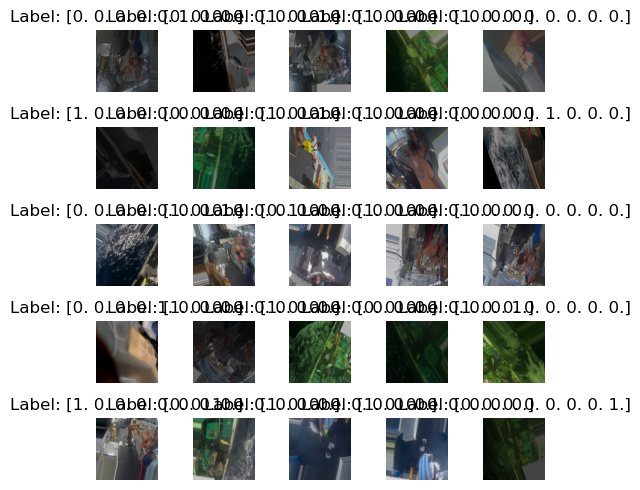

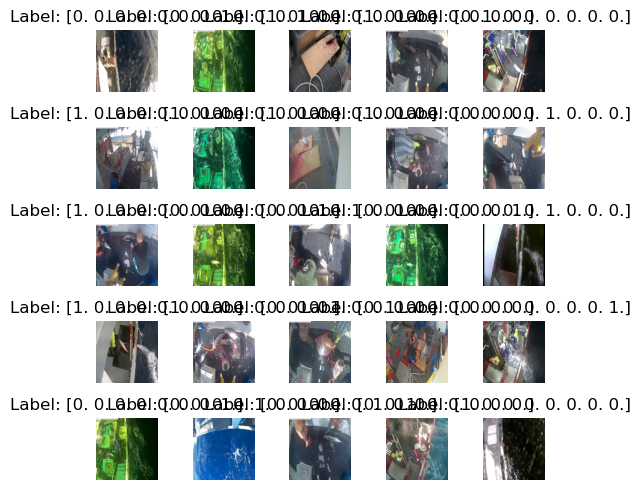

{0: 0.27445454545454545, 1: 2.35859375, 2: 4.057795698924731, 3: 7.120283018867925, 4: 1.0144489247311828, 5: 1.5789748953974896, 6: 2.695535714285714, 7: 0.6428875638841567}


In [8]:
"""
DATAGENS 
"""
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


# Create an ImageDataGenerator with data augmentation for training and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    channel_shift_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    featurewise_center=True,
    featurewise_std_normalization=True,
    zca_whitening=True,
    brightness_range=[0.2, 1.0],
    fill_mode='nearest'
)

# Create a separate ImageDataGenerator for validation with normalization only
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the training dataset
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
)

# Load and preprocess the validation dataset
validation_generator = val_datagen.flow_from_directory(
    'data/valid/',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
)

images, labels = train_generator.next()
fig, axes = plt.subplots(5, 5, figsize=(5, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# show images from validation set
images, labels = validation_generator.next()
fig, axes = plt.subplots(5, 5, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()




"""
Test weighted classes to solve class imbalance
"""
from sklearn.utils.class_weight import compute_class_weight

classes = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(classes), y=classes)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)


In [20]:
"""
This part of the code sets up the CNN model
"""
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Activation, BatchNormalization, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
import keras.regularizers as regularizers
from keras.applications import VGG16
from keras.applications import EfficientNetV2S
from keras.applications import EfficientNetB0
from keras.applications.efficientnet import preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import Adam
from keras.regularizers import l2
import tensorflow as tf


# TODO 
# k-fold cross validation?
# A model to define 'fish' and then a model to identify that fish?

# Check if keras is using cpu or gpu
print(f"GPU: {tf.config.list_physical_devices('GPU')}")
print(tf.compat.v1.keras.backend)


# Define hyperparameters
input_shape = (299, 299, 3)
num_classes = 8


# VGG16 Model Setup with ImageNet weights
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


# Create and compile the model 
adam_optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])
print(model.summary())


# Run the model
model.fit(
    train_generator,
    steps_per_epoch=32, # num training samples (1600) / batchsize(32) = 50
    epochs=32,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    validation_steps=len(validation_generator),
)

# Save the model
version = 'EfficientNetB0'
model.save(f'model{version}.keras')
print(f'model performance: {model.compiled_metrics.metrics}')

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<module 'keras.api._v1.keras.backend' from '/home/rashaka/.local/lib/python3.10/site-packages/keras/api/_v1/keras/backend/__init__.py'>
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 299, 299, 3)          0         ['input_6[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, 299, 299, 3)          7         ['rescaling_7[0][0]']         
 tion)                                                                            

/home/rashaka/.local/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/home/rashaka/.local/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1885: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/32


2023-12-01 15:04:28.501610: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 30s 395ms/step - loss: 3.0015 - accuracy: 0.1974 - val_loss: 3.7003 - val_accuracy: 0.1227
Epoch 2/32
32/32 [==============================] - 20s 614ms/step - loss: 2.6813 - accuracy: 0.2602 - val_loss: 6.8017 - val_accuracy: 0.1227
Epoch 3/32
32/32 [==============================] - 20s 623ms/step - loss: 2.6227 - accuracy: 0.2441 - val_loss: 6.6623 - val_accuracy: 0.1227
Epoch 4/32
32/32 [==============================] - 20s 612ms/step - loss: 2.3458 - accuracy: 0.3131 - val_loss: 3.1548 - val_accuracy: 0.1227
Epoch 5/32
32/32 [==============================] - 20s 629ms/step - loss: 2.0891 - accuracy: 0.3545 - val_loss: 2.8364 - val_accuracy: 0.1227
Epoch 6/32
32/32 [==============================] - 20s 632ms/step - loss: 1.9695 - accuracy: 0.3867 - val_loss: 3.2979 - val_accuracy: 0.1834
Epoch 7/32
32/32 [==============================] - 20s 620ms/step - loss: 1.8822 - accuracy: 0.3867 - val_loss: 4.4282 - val_accuracy: 0.0185
Epoch 8/32

In [21]:
"""
Display a confusion matrix
"""

from sklearn.metrics import confusion_matrix
import numpy as np

# Predict classes for the validation set
validation_generator.reset()
y_pred = model.predict(validation_generator, steps=len(validation_generator), verbose=1)
y_true = validation_generator.classes

# Get the class labels
class_labels = list(validation_generator.class_indices.keys())

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# To display the confusion matrix with class labels
print("Confusion Matrix with Class Labels:")
for i, row in enumerate(conf_matrix):
    print(f"{class_labels[i]}: {row}")

24/24 [==============================] - 4s 133ms/step
Confusion Matrix:
[[  0   0   0   0   4   0   0 340]
 [  0   0   0   0   1   0   0  39]
 [  0   0   0   0   0   0   0  24]
 [  0   0   0   0   0   0   0  14]
 [  0   3   0   0   0   0   0  90]
 [  0   0   0   0   1   0   0  59]
 [  0   0   0   0   0   0   0  36]
 [  0   2   0   0   1   0   0 144]]
Confusion Matrix with Class Labels:
ALB: [  0   0   0   0   4   0   0 340]
BET: [ 0  0  0  0  1  0  0 39]
DOL: [ 0  0  0  0  0  0  0 24]
LAG: [ 0  0  0  0  0  0  0 14]
NoF: [ 0  3  0  0  0  0  0 90]
OTHER: [ 0  0  0  0  1  0  0 59]
SHARK: [ 0  0  0  0  0  0  0 36]
YFT: [  0   2   0   0   1   0   0 144]


In [23]:
"""
Now run our trained model on the test set and create a submission csv file
"""
import keras
from tensorflow.keras.models import load_model
import sys


# Load the model 
model = load_model(f'model{version}.keras')

# Load the first test set, test_stg1
# Submission must be a combination of test_stg1 (1000) and test_stg2 (12153) = 13153
test_set1 = glob('data/test_stg1/*.jpg')
test_set2 = glob('data/test_stg2/*.jpg')

# Each image name must be called 'test_stg1/image_000001.jpg', for example
for i, image in enumerate(test_set1):
    test_set1[i] = image
for i, image in enumerate(test_set2):
    test_set2[i] = image
    # print(image) #'data/' + 'test_stg2/' + os.path.basename(image)
test_set = test_set1 + test_set2
# test_set=test_set1
print(test_set[0:10])


# Create a dataframe to hold the predictions
submission = pd.DataFrame(columns=['image', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT'])

# For each image in the test set, run the models prediction and save it to the submission df
# It takes about a min to run on test_stg1 for me (Karl). 
# It takes about 15 min to run the combined test_stg1 and test_stg2
# for each iteration, it takes 20 to 40ms to run. 
for i, image in enumerate(test_set):
    # Preprocess the test images
    test_image = test_set[i]
    test_image = tf.keras.preprocessing.image.load_img(test_image, target_size=input_shape)
    test_image = tf.keras.preprocessing.image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    test_image = keras.applications.mobilenet.preprocess_input(test_image)

    # Run the prediction 
    prediction = model.predict(test_image)

    # Get the predicted class
    # The prediction array is a list of probabilities for each class
    # For each prediction, map the prediction to the name of the class
    # train_generator.class_indices is a dictionary of the classes of fish and their indices
    keys = list(train_generator.class_indices.keys())

    # Create a dictionary of the predictions
    # Looks like this: 
    #  {'ALB': 1.3623509e-07, 'BET': 9.1926294e-20,
    #   'DOL': 2.9418256e-16, 'LAG': 1.9241103e-13, 'NoF': 0.0019608391, 
    #   'OTHER': 1.6155835e-11, 'SHARK': 2.625621e-13, 'YFT': 0.99803907}
    prediction_dict = dict(zip(keys, prediction[0]))
    # print(prediction_dict)

    # Add the prediction to the dataframe
    if test_set[i].split("/")[1] == "test_stg2":
        submission.loc[i, 'image'] = os.path.join('test_stg2/', os.path.basename(test_set[i]))

    else: 
        submission.loc[i, 'image'] = os.path.basename(test_set[i])
    for key in keys:
        submission.loc[i, key] = prediction_dict[key]

    # Uncomment the break if you want to test 
    # break


# Print the head, does it look okay?
print(submission.columns)
print(submission.head())

# Save the dataframe to a csv file :)
submission.to_csv('submission.csv', index=False)



['data/test_stg1/img_02666.jpg', 'data/test_stg1/img_04949.jpg', 'data/test_stg1/img_01976.jpg', 'data/test_stg1/img_01966.jpg', 'data/test_stg1/img_03181.jpg', 'data/test_stg1/img_07149.jpg', 'data/test_stg1/img_03043.jpg', 'data/test_stg1/img_01983.jpg', 'data/test_stg1/img_06571.jpg', 'data/test_stg1/img_01618.jpg']
1/1 [==============================] - 0s 16ms/step


In [ ]:
import os

cur_dir = os.getcwd()
image_path = os.path.join(cur_dir, 'data', 'test_stg2', 'image_07462.jpg')

if os.path.exists(image_path):
    print(f"The file exists: {image_path}")
else:
    print(f"The file does not exist: {image_path}")


The file exists: /home/rashaka/Desktop/Programing/CodClassifier/data/test_stg2/image_07462.jpg
